<a href="https://colab.research.google.com/github/Thuan-Pham/NLP_Twitter_Sentiment_Analysis/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import thư viện

In [ ]:
## Kết nối Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
folder = '/content/gdrive/My Drive'

Mounted at /content/gdrive


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
import sklearn
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing import sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout,Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')
import time
from wordcloud import WordCloud
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline


## **Đọc dữ liệu và đặt tên cho cột**

In [ ]:
# Specify the encoding parameter
data = pd.read_csv('',header = None, encoding='latin')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
# Đặt tên cho các cột dữ liệu.
data.columns = ['target', 'id', 'date', 'query', 'user_id', 'text']
data.head()

,target,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Kiểm tra giá trị cột target
unique_values = data['target'].unique()
print(unique_values)

[0 4]


# **Trạng thái dữ liệu trước khi xử lý**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   target   1600000 non-null  int64 
 1   id       1600000 non-null  int64 
 2   date     1600000 non-null  object
 3   query    1600000 non-null  object
 4   user_id  1600000 non-null  object
 5   text     1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Data preprocessing

Xóa cột dữ liệu không cần thiết

In [ ]:
# Xóa cột không cần thiết cho quá trình thực hiện sau này.
data = data.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [ ]:
print(f'Số dòng của bộ dữ liệu là:{data.shape[0]} dòng')
print(f'Số cột của bộ dữ liệu là:{data.shape[1]} cột')

Số dòng của bộ dữ liệu là:1600000 dòng
Số cột của bộ dữ liệu là:2 cột


In [ ]:
data.columns

Index(['target', 'text'], dtype='object')

Vì bộ dữ liệu chỉ có 2 giá trị target là 0 và 4 nên ta đổi giá trị 4 thành 1 nhưng vẫn giữ nguyên ý nghĩa là positive

In [ ]:
data['target'][data['target']==4]=1
data.tail()

,target,text
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
# Kiểm tra giá trị cột target
unique_values = data['target'].unique()
print(unique_values)

[0 1]


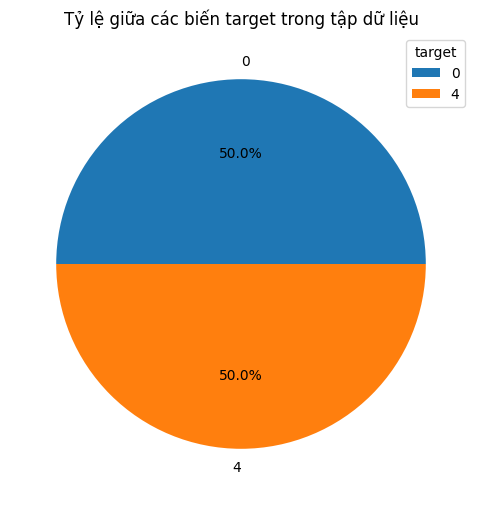

In [ ]:
target_counts = data['target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.title('Tỷ lệ giữa các biến target trong tập dữ liệu')
plt.legend(title="target", labels=target_counts.index)
plt.show()

In [ ]:
# Kiểm tra nếu có bất kỳ giá trị nào thiếu trong toàn bộ DataFrame
missing_any = data.isnull().any().sum()

# Kiểm tra nếu có bất kỳ dòng nào trùng lặp trong toàn bộ DataFrame
duplicate_any = data.duplicated().any()

print("Có giá trị thiếu:", missing_any)
print("Có dòng trùng lặp:", duplicate_any)

Có giá trị thiếu: 0
Có dòng trùng lặp: True


In [ ]:
# Kiểm tra dòng trùng lặp
duplicate_mask = data.duplicated()
# Lọc và in ra các dòng trùng lặp
duplicate_rows = data[duplicate_mask]
print("Số dòng trùng lặp là:", len(duplicate_rows))
duplicate_rows

Số dòng trùng lặp là: 16309


,target,text
1940,0,and so the editing of 3000 wedding shots begins
2149,0,"im lonely keep me company! 22 female, california"
3743,0,I'm not liking that new iTunes Pricing at all....
3746,0,"cant eat, drink or breath properly thanks to t..."
4163,0,has a cold
...,...,...
1599450,1,Good morning!
1599501,1,getting used to twitter
1599531,1,@KhloeKardashian Definitely my Mom. And Angeli...
1599678,1,goodmorning


In [ ]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]
data = pd.concat([data_pos, data_neg])

In [ ]:
data = data.drop_duplicates(subset='text', keep='first')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1581466 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1581466 non-null  int64 
 1   text    1581466 non-null  object
dtypes: int64(1), object(1)
memory usage: 36.2+ MB


Downsapling 1m6 to 40000

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 800000 to 20087
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  40000 non-null  int64 
 1   text    40000 non-null  object
dtypes: int64(1), object(1)
memory usage: 937.5+ KB


## Text Mining

chuyển tất cả ký tự thành chữ viết thường

In [ ]:
data['text']=data['text'].str.lower()

loại bỏ stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords_list = stopwords.words('english')

In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

Loại bỏ dấu câu

In [ ]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [ ]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

20083                cant sleep always happens im away bed
20084      markinscotland super ive soggy corn flakes eugh
20085                                   bl dwam maly moood
20086    slumdrink millionaire tonight exhaustedand ain...
20087    aaah ipod appears broken stuck screen play cha...
Name: text, dtype: object

Loại bỏ các ký tự lặp lại nhiều lần

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

20083                  cant slep always hapens im away bed
20084       markinscotland super ive sogy corn flakes eugh
20085                                     bl dwam maly mod
20086    slumdrink milionaire tonight exhaustedand aint...
20087    ah ipod apears broken stuck scren play charge ...
Name: text, dtype: object

Loại bỏ mention

In [ ]:
def cleaning_mention(data):
    return re.sub('@[^\s]+', ' ', data)
data['text']= data['text'].apply(lambda x: cleaning_mention(x))
data['text'].tail()

20083                  cant slep always hapens im away bed
20084       markinscotland super ive sogy corn flakes eugh
20085                                     bl dwam maly mod
20086    slumdrink milionaire tonight exhaustedand aint...
20087    ah ipod apears broken stuck scren play charge ...
Name: text, dtype: object

Loại bỏ URL

In [ ]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

20083                  cant slep always hapens im away bed
20084       markinscotland super ive sogy corn flakes eugh
20085                                     bl dwam maly mod
20086    slumdrink milionaire tonight exhaustedand aint...
20087    ah ipod apears broken stuck scren play charge ...
Name: text, dtype: object

Loại bỏ ký tự số

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

20083                  cant slep always hapens im away bed
20084       markinscotland super ive sogy corn flakes eugh
20085                                     bl dwam maly mod
20086    slumdrink milionaire tonight exhaustedand aint...
20087    ah ipod apears broken stuck scren play charge ...
Name: text, dtype: object

Loại bỏ các ký tự không thuộc alphabet

In [ ]:
def remove_non_alphabetic(text):
    return re.sub('[^A-Za-z]', ' ', text)
data['text'] = data['text'].apply(lambda x: remove_non_alphabetic(x))
data['text'].tail()

20083                  cant slep always hapens im away bed
20084       markinscotland super ive sogy corn flakes eugh
20085                                     bl dwam maly mod
20086    slumdrink milionaire tonight exhaustedand aint...
20087    ah ipod apears broken stuck scren play charge ...
Name: text, dtype: object

Phân tách từ

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800003    [sick, realy, cheap, hurts, much, eat, real, f...
800004                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

Chuẩn hóa từ

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()

800000              [love, healthuandpets, u, guy, r, best]
800001    [im, meting, one, besties, tonight, cant, wait...
800002    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800003    [sick, realy, cheap, hurt, much, eat, real, fo...
800004                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

Chia tập dữ liệu

In [ ]:
X=data.text
y=data.target

In [ ]:
## Chia tập dữ liệu thành training, test sets theo tỷ lệ 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
print(X_train)

11422     [triplethreat, ugly, wanted, go, international...
806998                            [fisbed, get, back, work]
808397    [kindly, sugest, frozen, yogurt, take, edge, o...
1593           [runawaystarling, unfort, msn, douche, half]
814069                             [asistir, band, brother]
                                ...                        
11049     [worked, enough, time, hear, leicester, score,...
10308                   [civil, procedure, review, lecture]
806685                            [dawnmaloney, wow, limit]
15410     [heyimash, ugh, wish, zach, spech, monday, mor...
3722      [swanage, fieldtrip, legendary, carnage, reaso...
Name: text, Length: 32000, dtype: object


In [ ]:
print(X_train.shape)

(32000,)


## EDA

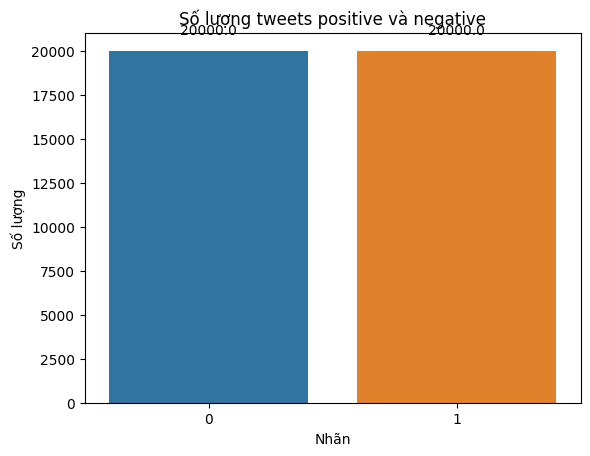

In [ ]:
new_palette = {0: '#1f77b4', 1: '#ff7f0e'}

# Vẽ biểu đồ cột với màu mới
sns.countplot(x='target', data=data, palette=new_palette)

# Hiển thị số lượng trên đầu các cột
for p in plt.gca().patches:
    plt.gca().annotate(round(p.get_height(), 1), (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', xytext=(0, 10), textcoords='offset points', color='black')
# Đặt nhãn và tiêu đề
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.title('Số lượng tweets positive và negative')

# Hiển thị biểu đồ
plt.show()

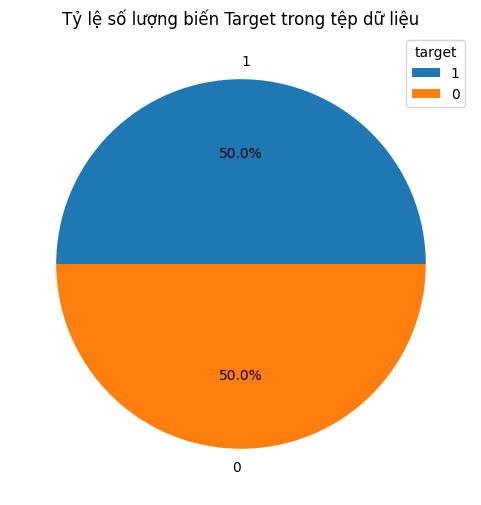

In [ ]:
target_counts = data['target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.title('Tỷ lệ số lượng biến Target trong tệp dữ liệu')
plt.legend(title="target", labels=target_counts.index)
plt.show()

### Full Target

Positive



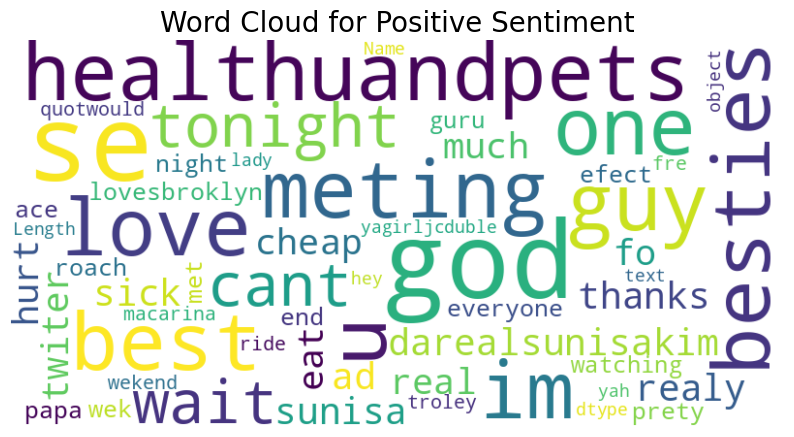

Negative



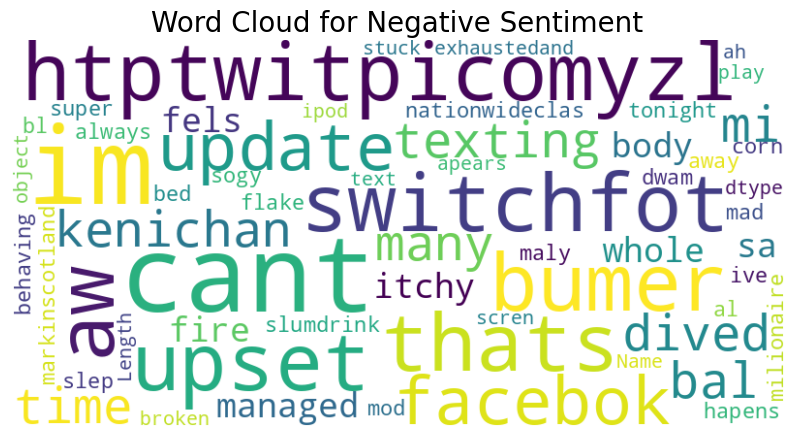

In [ ]:
# Tạo một DataFrame cho từng lớp
positive_df = data[data['target'] == 1]
negative_df = data[data['target'] == 0]

# Hàm để tạo và hiển thị Word Cloud
def create_and_display_wordcloud(text_data, title):
    wordcloud = WordCloud(width = 800, height = 400,
                          random_state=21, max_font_size=110,
                          background_color='white', colormap='viridis').generate(str(text_data))

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Tạo và hiển thị Word Cloud cho lớp Positive
print('Positive\n')
create_and_display_wordcloud(positive_df['text'], "Word Cloud for Positive Sentiment")

# Tạo và hiển thị Word Cloud cho lớp Negative
print('Negative\n')
create_and_display_wordcloud(negative_df['text'], "Word Cloud for Negative Sentiment")

## Prepare the Data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
print(X_train)

11422     [triplethreat, ugly, wanted, go, international...
806998                            [fisbed, get, back, work]
808397    [kindly, sugest, frozen, yogurt, take, edge, o...
1593           [runawaystarling, unfort, msn, douche, half]
814069                             [asistir, band, brother]
                                ...                        
11049     [worked, enough, time, hear, leicester, score,...
10308                   [civil, procedure, review, lecture]
806685                            [dawnmaloney, wow, limit]
15410     [heyimash, ugh, wish, zach, spech, monday, mor...
3722      [swanage, fieldtrip, legendary, carnage, reaso...
Name: text, Length: 32000, dtype: object


In [ ]:
X_train_str = [' '.join(words) for words in X_train]
X_test_str = [' '.join(words) for words in X_test]

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)
test_tfidf = tfidf_vectorizer.transform(X_test_str)

In [ ]:
# Khởi tạo mô hình TF-IDF với số lượng từ vựng tối đa là 5000
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit và chuyển đổi dữ liệu train
train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)

# Chuyển đổi dữ liệu test
test_tfidf = tfidf_vectorizer.transform(X_test_str)

In [ ]:
X_train_shape = train_tfidf.shape
X_test_shape = test_tfidf.shape
y_train_shape = (len(y_train),)
y_test_shape = (len(y_test),)

X_train_shape, X_test_shape, y_train_shape, y_test_shape

((32000, 5000), (8000, 5000), (32000,), (8000,))

# **Naive bayes**



In [ ]:
# Xây dựng mô hình Naïve Bayes
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(train_tfidf, y_train)

MultinomialNB()

In [ ]:
nb_pred = naive_bayes_model.predict(test_tfidf)

In [ ]:
# Đánh giá mô hình
print("Confusion Matrix:")
print(confusion_matrix(y_test, nb_pred))
print("\nClassification Report:")
print(classification_report(y_test, nb_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, nb_pred))

Confusion Matrix:
[[3045  953]
 [1074 2928]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      3998
           1       0.75      0.73      0.74      4002

    accuracy                           0.75      8000
   macro avg       0.75      0.75      0.75      8000
weighted avg       0.75      0.75      0.75      8000


Accuracy Score:
0.746625


In [ ]:
from sklearn import metrics

In [ ]:
# Ma trận nhầm lẫn
def plot_confusion_matrix(model, test_data, test_labels):
    predictions = model.predict(test_data)
    cm = confusion_matrix(test_labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt=".2%", cmap="Blues",
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix (Percentage)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

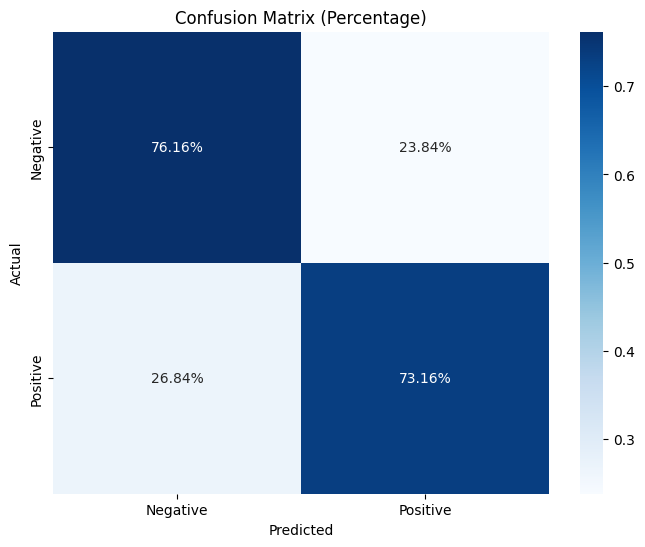

In [ ]:
# Plot confusion matrix for Naive Bayes model
plot_confusion_matrix(naive_bayes_model, test_tfidf, y_test)

In [ ]:
# Đánh giá hiệu suất
accuracy = metrics.accuracy_score(y_test, nb_pred)
precision = metrics.precision_score(y_test, nb_pred)
recall = metrics.recall_score(y_test, nb_pred)
f1_score = metrics.f1_score(y_test, nb_pred)

In [ ]:
# In kết quả
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.746625
Precision: 0.7544447307395001
Recall: 0.7316341829085458
F1 Score: 0.7428643917290372


# **Logistic re**


In [ ]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(train_tfidf, y_train)

LogisticRegression(max_iter=500)

In [ ]:
lr_pred = lr_model.predict(test_tfidf)

In [ ]:
# Đánh giá mô hình
print("Ma trận nhầm lẫn (Confusion Matrix):")
print(confusion_matrix(y_test, lr_pred))
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, lr_pred))

Ma trận nhầm lẫn (Confusion Matrix):
[[2959 1039]
 [ 938 3064]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      3998
           1       0.75      0.77      0.76      4002

    accuracy                           0.75      8000
   macro avg       0.75      0.75      0.75      8000
weighted avg       0.75      0.75      0.75      8000


Accuracy Score:
0.752875


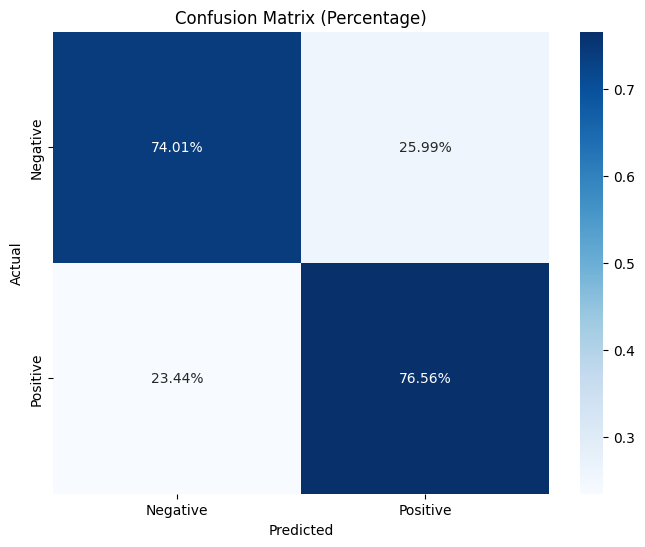

In [ ]:
# Plot confusion matrix for Naive Bayes model
plot_confusion_matrix(lr_model, test_tfidf, y_test)

In [ ]:
# Đánh giá hiệu suất
accuracy = metrics.accuracy_score(y_test, lr_pred)
precision = metrics.precision_score(y_test, lr_pred)
recall = metrics.recall_score(y_test, lr_pred)
f1_score = metrics.f1_score(y_test, lr_pred)

In [ ]:
# In kết quả
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.752875
Precision: 0.7467706556178406
Recall: 0.7656171914042978
F1 Score: 0.7560764959901295


# **L2**

In [ ]:
# Regularized Logistic Regression (L2)
lr_l2_model = LogisticRegression(penalty='l2', max_iter=500)
lr_l2_model.fit(train_tfidf, y_train)
lr_l2_pred = lr_l2_model.predict(test_tfidf)
print("Regularized Logistic Regression (L2) Accuracy:", accuracy_score(y_test, lr_l2_pred))

Regularized Logistic Regression (L2) Accuracy: 0.752875


In [ ]:
print(classification_report(y_test, lr_l2_pred))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      3998
           1       0.75      0.77      0.76      4002

    accuracy                           0.75      8000
   macro avg       0.75      0.75      0.75      8000
weighted avg       0.75      0.75      0.75      8000



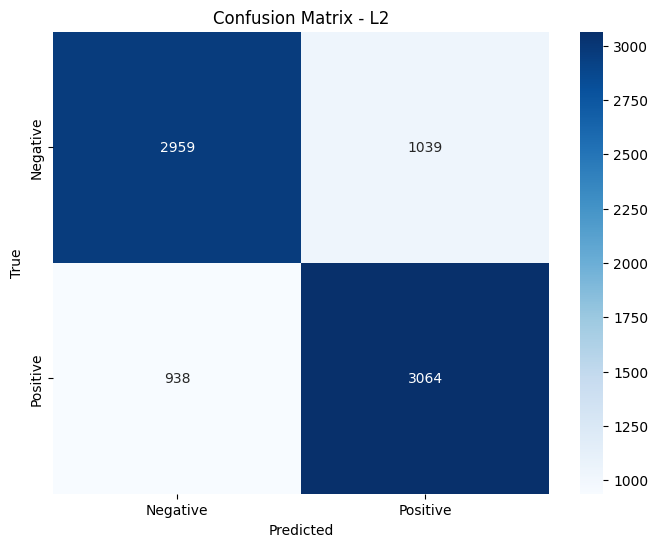

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, lr_l2_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - L2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

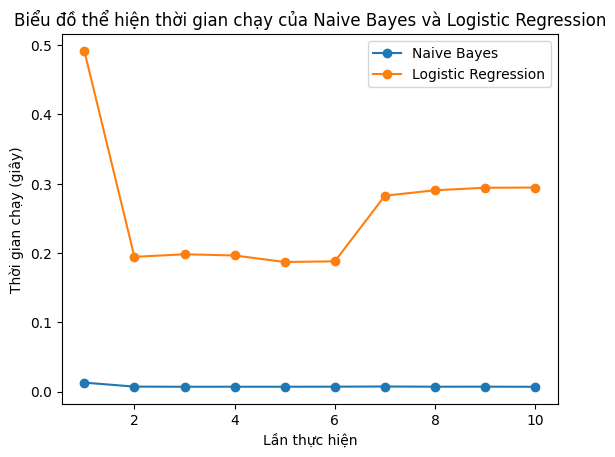

In [ ]:
# Thực hiện 10 lần và tính thời gian chạy cho Naive Bayes
nb_times = []
for _ in range(10):
    start_time = time.time()
    nb_model = MultinomialNB()
    nb_model.fit(train_tfidf, y_train)
    nb_time = time.time() - start_time
    nb_times.append(nb_time)

# Thực hiện 10 lần và tính thời gian chạy cho Logistic Regression
lr_times = []
for _ in range(10):
    start_time = time.time()
    lr_model = LogisticRegression()
    lr_model.fit(train_tfidf, y_train)
    lr_time = time.time() - start_time
    lr_times.append(lr_time)

# Vẽ biểu đồ xu hướng thời gian chạy
plt.plot(range(1, 11), nb_times, label='Naive Bayes', marker='o')
plt.plot(range(1, 11), lr_times, label='Logistic Regression', marker='o')
plt.xlabel('Lần thực hiện')
plt.ylabel('Thời gian chạy (giây)')
plt.title('Biểu đồ thể hiện thời gian chạy của Naive Bayes và Logistic Regression')
plt.legend()
plt.show()

# **DEEP LEARNING**

In [ ]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [ ]:
sequences_matrix.shape

(40000, 500)

In [ ]:
## Chia tập dữ liệu thành training, test sets theo tỷ lệ 80:20
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(sequences_matrix, y, test_size=0.2, random_state=2)

In [ ]:
def tensorflow_based_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = tensorflow_based_model()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
start_time = time.time()
history=model.fit(X_train_D,y_train_D,batch_size=120,epochs=10, validation_split=0.1)
end_time = time.time()
print('Training finished !!')
elapsed_time = end_time - start_time
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

Epoch 1/10
240/240 [==============================] - 177s 736ms/step - loss: 0.6124 - accuracy: 0.6541 - val_loss: 0.5286 - val_accuracy: 0.7422
Epoch 2/10
240/240 [==============================] - 168s 703ms/step - loss: 0.5123 - accuracy: 0.7506 - val_loss: 0.5223 - val_accuracy: 0.7394
Epoch 3/10
240/240 [==============================] - 173s 722ms/step - loss: 0.4963 - accuracy: 0.7607 - val_loss: 0.5278 - val_accuracy: 0.7369
Epoch 4/10
240/240 [==============================] - 170s 711ms/step - loss: 0.4964 - accuracy: 0.7616 - val_loss: 0.5825 - val_accuracy: 0.6862
Epoch 5/10
240/240 [==============================] - 172s 715ms/step - loss: 0.4911 - accuracy: 0.7635 - val_loss: 0.5203 - val_accuracy: 0.7428
Epoch 6/10
240/240 [==============================] - 170s 706ms/step - loss: 0.4697 - accuracy: 0.7781 - val_loss: 0.5180 - val_accuracy: 0.7434
Epoch 7/10
240/240 [==============================] - 173s 722ms/step - loss: 0.4608 - accuracy: 0.7818 - val_loss: 0.5237 -

In [ ]:
accr1 = model.evaluate(X_test_D,y_test_D)

250/250 [==============================] - 16s 63ms/step - loss: 0.5632 - accuracy: 0.7424


In [ ]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

Test set
  Accuracy: 0.74


In [ ]:
y_pred_D = model.predict(X_test_D)
y_pred_D = (y_pred_D > 0.5)

250/250 [==============================] - 16s 63ms/step


In [ ]:
accuracy = accuracy_score(y_test_D, y_pred_D)
print("Accuracy:", accuracy)

Accuracy: 0.742375


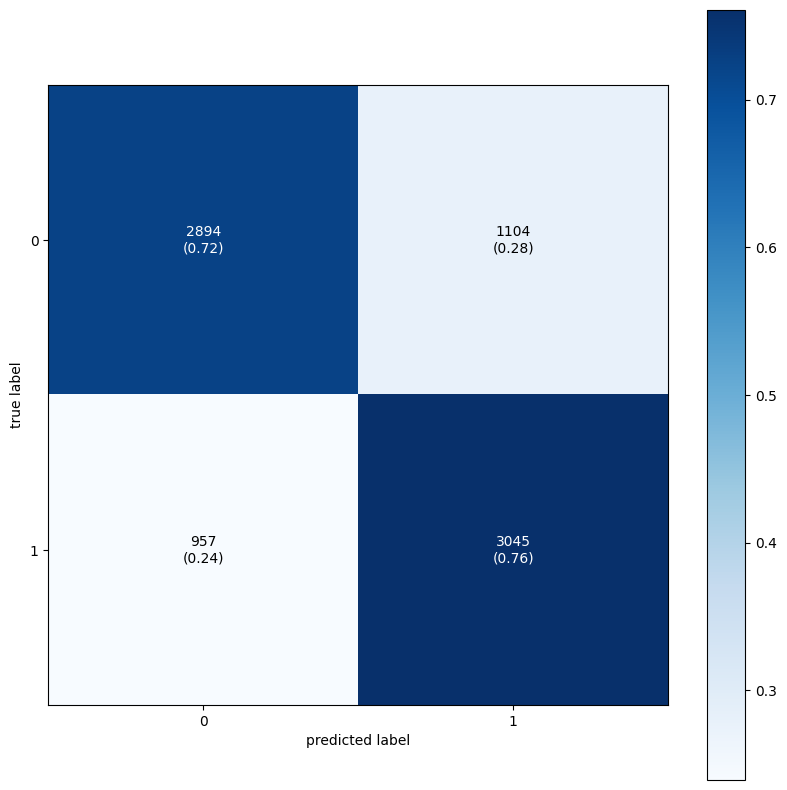

In [ ]:
CR=confusion_matrix(y_test_D, y_pred_D)
fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()